In [1]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
from scipy import stats as st
import statistics

In [2]:
# load plant growth dataset

file_path = "plant growth.csv"
p_g_df = pl.read_csv(file_path).select(["Index", "Weight", "Group"])

groups = list(set(p_g_df.select("Group").to_series().to_list()))

print(f"The groups are {groups}")

ctrl_weight = p_g_df.filter(pl.col("Group") == "ctrl").select("Weight").to_series().to_numpy()

trt1_weight = p_g_df.filter(pl.col("Group") == "trt1").select("Weight").to_series().to_numpy()

trt2_weight = p_g_df.filter(pl.col("Group") == "trt2").select("Weight").to_series().to_numpy()


p_g_df.head(10)



The groups are ['trt2', 'ctrl', 'trt1']


Index,Weight,Group
i64,f64,str
1,4.17,"""ctrl"""
2,5.58,"""ctrl"""
3,5.18,"""ctrl"""
4,6.11,"""ctrl"""
5,4.5,"""ctrl"""
6,4.61,"""ctrl"""
7,5.17,"""ctrl"""
8,4.53,"""ctrl"""
9,5.33,"""ctrl"""


## To analyze if there are difference between the three groups, we can use one way ANOVA

# First assumption 
is that there is one continuous dependent variable, which we have as "Weight"

# Second assumption 
is that we have an independent variable that consists of three or more categorical, independent variables, which we have as the column "Group" 

# Third assumption
is that the data should have independence of observations, which means that there is no relationship between the observations in each group of the independent variable or among the groups themselves. The data set satisfies this assumption as the experiment is taken independent of each observations.

# Fourth assumption

is that there are no extreme outliers in the three of more groups of the independent variables. We can view that in a box plot

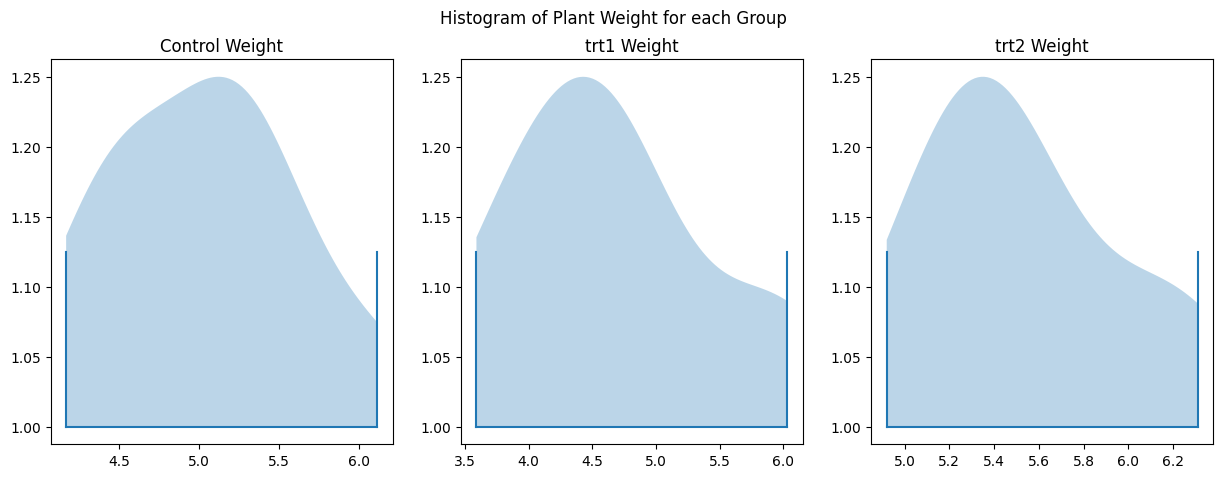

In [3]:
# First, check sampling distribution

fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle("Histogram of Plant Weight for each Group")

axs[0].violinplot(ctrl_weight, side='high', vert=False)
axs[0].set_title("Control Weight")

axs[1].violinplot(trt1_weight, side='high', vert=False)
axs[1].set_title("trt1 Weight")

axs[2].violinplot(trt2_weight, side='high', vert=False)
axs[2].set_title("trt2 Weight")

plt.show()

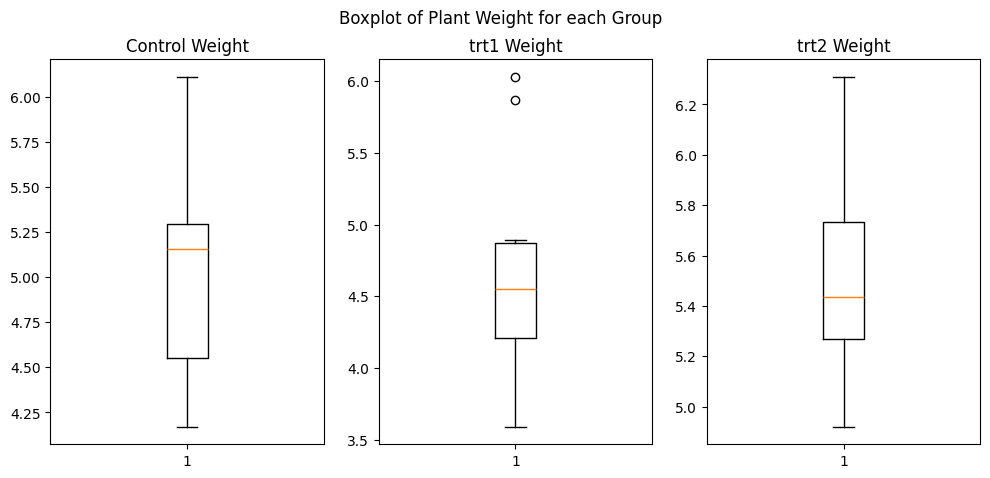

In [4]:
fig, axs = plt.subplots(1,3, figsize=(12,5))
fig.suptitle("Boxplot of Plant Weight for each Group")

axs[0].boxplot(ctrl_weight)
axs[0].set_title("Control Weight")

axs[1].boxplot(trt1_weight)
axs[1].set_title("trt1 Weight")

axs[2].boxplot(trt2_weight)
axs[2].set_title("trt2 Weight")

plt.show()

In [5]:
# Get Q1, Q3, and interquartile range for trt1

trt1_q1 = np.quantile(trt1_weight, 0.25)

trt1_q3 = np.quantile(trt1_weight, 0.75)

trt1_IQR = trt1_q3 - trt1_q1

print(f"The third quartile is {round(trt1_q3, 2)}, and the third quartile + 3*IQR is {round(trt1_q3 + (3*trt1_IQR))}")

The third quartile is 4.87, and the third quartile + 3*IQR is 7


Since the most extreme outlier of the data set is less than the third quartile + 3*IQR (6 < 7), there are no extreme outliers, and assumption 4 is met.

# Assumption 5 
is that the dependent variable should be approximately normally distributed for each group of the independent variable.

In [6]:
# Shapiro-Wilk Test for normality

for idx, data in enumerate([ctrl_weight, trt1_weight, trt2_weight]):
    test_stat, pval = st.shapiro(data)
    print(f"The shapiro test statistic for the group {groups[idx]} is {test_stat} and its p value is {pval} ")

The shapiro test statistic for the group trt2 is 0.9566814905276368 and its p value is 0.7474734451902585 
The shapiro test statistic for the group ctrl is 0.9304106932921845 and its p value is 0.45194395810927823 
The shapiro test statistic for the group trt1 is 0.9410051970546394 and its p value is 0.5642518926711526 


Assumption 5 is met, since all p-values of the Shapiro-Wilk tests are are above 0.05.

# Assumption 6
is that there is a homogeneity of variances (i.e., the variance of the dependent variable is equal in each group of your independent variable).

In [7]:
# Levene's test

lev_stat, levpval = st.levene(ctrl_weight, trt1_weight, trt2_weight)
print(f"The Levene test statistic for plant weight across the three groups are {lev_stat} and its p value is {levpval} ")

The Levene test statistic for plant weight across the three groups are 1.1191856948703909 and its p value is 0.3412266241254737 


Assumption 6 is met, since the p-value for the levene's test is greater than 0.05.

In [8]:
# doing one way anova

anova_stat, anova_p = st.f_oneway(ctrl_weight, trt1_weight, trt2_weight)

print(f"The p-value for the one way anova between the three groups are {anova_p}")

t_stat_ctrl_trt1, tpval_ctrl_trt1 = st.ttest_ind(ctrl_weight, trt1_weight)
print(f"The Independent samples t-test test statistic between ctrl and trt1 is {t_stat_ctrl_trt1} and its p value is {tpval_ctrl_trt1} ")

t_stat_ctrl_trt2, tpval_ctrl_trt2 = st.ttest_ind(ctrl_weight, trt2_weight)
print(f"The Independent samples t-test test statistic between ctrl and trt2 is {t_stat_ctrl_trt2} and its p value is {tpval_ctrl_trt2} ")

t_stat_trt1_trt2, tpval_trt1_trt2 = st.ttest_ind(trt1_weight, trt2_weight)
print(f"The Independent samples t-test test statistic between trt1 and trt2 is {t_stat_trt1_trt2} and its p value is {tpval_trt1_trt2} ")

The p-value for the one way anova between the three groups are 0.0159099583256229
The Independent samples t-test test statistic between ctrl and trt1 is 1.1912603818487009 and its p value is 0.2490231659730067 
The Independent samples t-test test statistic between ctrl and trt2 is -2.1340204531240654 and its p value is 0.04685138491157358 
The Independent samples t-test test statistic between trt1 and trt2 is -3.0100985421243616 and its p value is 0.0075184261182198574 


There is no significant difference between the ctrl group and trt1, as shown by a p-value greater than 0.05 (0.24).

There is a significant difference, however, between the ctrl group and trt2, as well as between trt1 and trt2, with p-values of 0.047 and 0.008, respectively.

The one way anova shows that there is a significant difference between the three groups, with a p-value less than 0.05 (0.016). However, the independent t-test have shown that this significance difference doesn't apply between the ctrl group and trt1.